# 10장. 시퀀스를 예측하는 머신러닝 모델 만들기

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch10/10-sequence-prediction.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch10/10-sequence-prediction.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

## 윈도우 데이터셋 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

1. 0~9까지의 값을 담는 데이터 셋을 생성 = dataset   
2. dataset.window() 함수를 이용하여 데이터셋을 5개 항목으로 구성된 윈도로 나누고, shift=항목 갯수를 설정.   
drop_remainder=True로 설정하여 데이터셋의 마지막 부분에서 윈도 크기보다 작은 갯수가 남으면 해당 윈도를 drop   
3. 정의된 윈도를 사용하여 데이터셋 분할을 수행: dataset.flat_map() 내에 5개 항목을 가진 배치를 생성   
window.batch(배치항목 갯수)   
4. n개의 값을 특성으로 사용하고, 이어지는 하나의 값을 레이블로 사용하는 훈련 데이터 생성   
dataset.map() 내에 람다 함수를 적용하여, 각 윈도를 마지막 이전의 값과 마지막 값으로 분리   

In [10]:
dataset = tf.data.Dataset.range(10)                         # 1. 0~9까지의 값을 담는 데이터 셋을 생성 = dataset   
dataset = dataset.window(5, shift=1, drop_remainder=True)   # 2. 윈도우 크기 = 5, shift = 이동 거리, dataset의 마지막 원소까지만(drop_remainder)
dataset = dataset.flat_map(lambda window: window.batch(5))  # 3. batch 사이즈를 윈도우 크기와 동일하게 5로 해서 1차원 배열로 
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [3]:
dataset = tf.data.Dataset.range(10)                                 # 1. 0~9까지의 값을 담는 데이터 셋을 생성 = dataset   
dataset = dataset.window(5, shift=1, drop_remainder=True)           # 2. 윈도우 크기 = 5, shift = 이동 거리, dataset의 마지막 원소까지만(drop_remainder)
dataset = dataset.flat_map(lambda window: window.batch(5))          # 3. batch 사이즈를 윈도우 크기와 동일하게 5로 해서 1차원 배열로
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))    # 4. dataset.map()함수를 이용해 window의 마지막 위치를 분리해준다.
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [11]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[2 3 4 5]
 [4 5 6 7]]
y =  [[6]
 [8]]
x =  [[3 4 5 6]
 [5 6 7 8]]
y =  [[7]
 [9]]
x =  [[1 2 3 4]
 [0 1 2 3]]
y =  [[5]
 [4]]


### 윈도우를 적용한 시계열 데이터셋 만들기
위의 과정을 함수화

In [2]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope) 
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)
series

array([ 32.48357 ,  29.395714,  33.40659 , ..., 148.681   , 145.67987 ,
       160.70773 ], dtype=float32)

In [33]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = (time, 0.1)
series = map(lambda time, slope: slope * time, series)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + (lambda time, slope: slope * time)(time, slope) 
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)
series

array([ 32.48357 ,  29.395714,  33.40659 , ..., 148.681   , 145.67987 ,
       160.70773 ], dtype=float32)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
        lambda window: (window[:-1], window[-1])
    )
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, 
                           shuffle_buffer_size)

In [5]:
dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
    print(feature)
    print(label)

tf.Tensor(
[[74.01205  73.393845 82.320206 83.27507  73.119415 71.615204 77.94125
  72.63366  78.373535 76.04119  67.26922  82.41057  83.48135  71.27087
  72.23311  75.4418   75.52976  76.99938  83.611145 72.53319 ]], shape=(1, 20), dtype=float32)
tf.Tensor([69.28865], shape=(1,), dtype=float32)


## DNN을 만들고 시퀀스 데이터로 훈련하기
tf.keras를 이용한 간단한 신경망 모델: 세 개의 밀집층으로 구성   
(1) 첫번째 층: window_size 크기를 입력받음   
(2) 마지막 출력 층: 예측값을 만듦.   

옵티마이저(SGD) 모델: tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)   
손실함수(MSE)와 옵티마이저(SGD)로 모델을 컴파일:   
model.compile(loss='mse', optimizer=옵티마이저(SGD) 모델)   

※ 참고: SGD   
SGD는 학습률(learning_rate)과 모멘텀(momentum) 매개변수로 값을 받아, 옵티마이저의 최적화 과정을 조정.   
momentum: 경사 하강법(gradient descent) 최적화 알고리즘의 한 종류.      
모멘텀 알고리즘: 누적된 과거 그래디언트가 지향하고 있는 어떤 방향을 현재 그래디언트에 보정하는 방식(일종의 관성, 가속도)      
https://tensorflow.blog/2017/03/22/momentum-nesterov-momentum   

In [6]:
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [7]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse",optimizer=sgd)

In [8]:
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 30ms/step - loss: 599.1078
Epoch 2/100
31/31 [==============================] - 0s 882us/step - loss: 64.6562
Epoch 3/100
31/31 [==============================] - 0s 767us/step - loss: 52.2397
Epoch 4/100
31/31 [==============================] - 0s 767us/step - loss: 51.6721
Epoch 5/100
31/31 [==============================] - 0s 895us/step - loss: 51.0574
Epoch 6/100
31/31 [==============================] - 0s 901us/step - loss: 50.9724
Epoch 7/100
31/31 [==============================] - 0s 901us/step - loss: 50.4122
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 49.6933
Epoch 9/100
31/31 [==============================] - 0s 970us/step - loss: 49.4766
Epoch 10/100
31/31 [==============================] - 0s 767us/step - loss: 49.4856
Epoch 11/100
31/31 [==============================] - 0s 803us/step - loss: 48.5036
Epoch 12/100
31/31 [==============================] - 0s 893us/step - loss: 48.1896
Epo

## DNN의 결과 평가하기

In [9]:
print(series[1000:1020])

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]


In [10]:
print(series[1020])

106.258606


In [11]:
print(model.predict(series[1000:1020][np.newaxis]))

[[103.46604]]


In [12]:
start_point = 1000

print(series[start_point:start_point+window_size])
print(series[start_point+window_size])
print(model.predict(
      series[start_point:start_point+window_size][np.newaxis]))

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
[[103.46604]]


## 전반적인 예측 살펴보기

In [13]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))

In [14]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [15]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

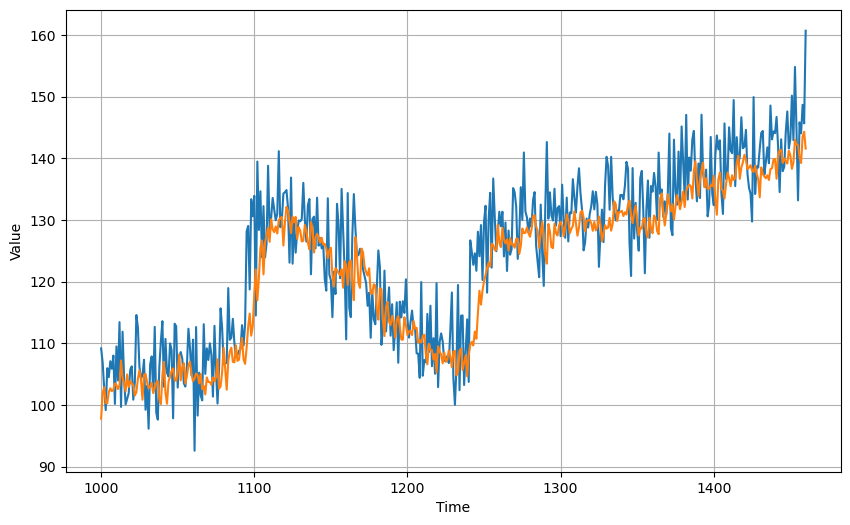

In [16]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0741963

## 학습률 튜닝
가능한 정확한 예측을 얻는 과정이 MAE를 최소화하는 과정   

In [18]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

에포크가 진행될 때마다 학습률이 위 식에 따라서 증가

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)   # 여기 learning_rate는 초깃값
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, 
                    callbacks=[lr_schedule], verbose=0)

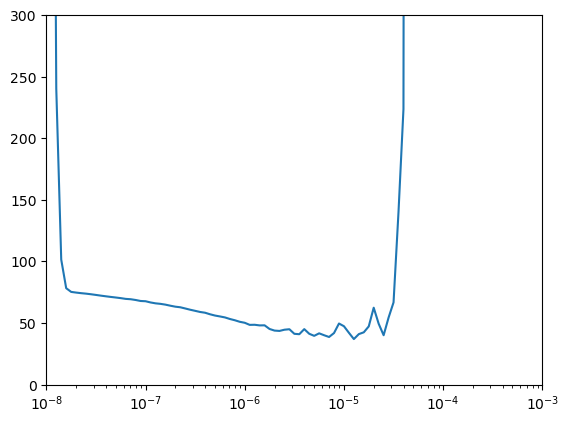

In [20]:
# learning_rate 스케줄에 따른 손실값 변화 눈으로 확인하기: 기준이 1e-8일 때
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

학습률 1e-6에서 다시 훈련

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse",optimizer=sgd)
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 1165.4292
Epoch 2/100
31/31 [==============================] - 0s 1000us/step - loss: 85.3271
Epoch 3/100
31/31 [==============================] - 0s 778us/step - loss: 49.8628
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 48.7084
Epoch 5/100
31/31 [==============================] - 0s 914us/step - loss: 48.5320
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 47.5769
Epoch 7/100
31/31 [==============================] - 0s 995us/step - loss: 48.6344
Epoch 8/100
31/31 [==============================] - 0s 856us/step - loss: 46.4299
Epoch 9/100
31/31 [==============================] - 0s 998us/step - loss: 46.3717
Epoch 10/100
31/31 [==============================] - 0s 893us/step - loss: 46.4480
Epoch 11/100
31/31 [==============================] - 0s 833us/step - loss: 47.4167
Epoch 12/100
31/31 [==============================] - 0s 939us/step - loss: 45.4232
Epoc

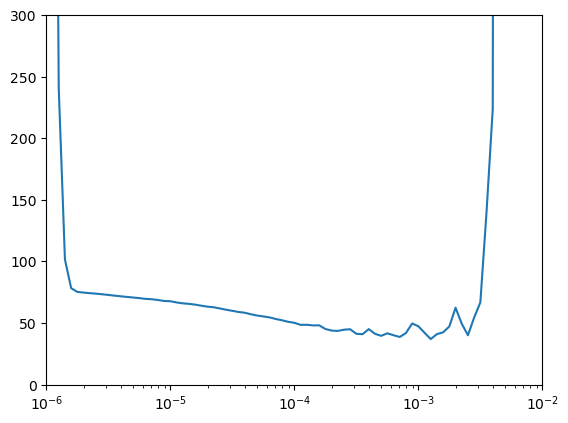

In [24]:
# learning_rate 스케줄에 따른 손실값 변화 눈으로 확인하기: 기준이 1e-6일 때
lrs = 1e-6 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-2, 0, 300])
plt.show()

In [22]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

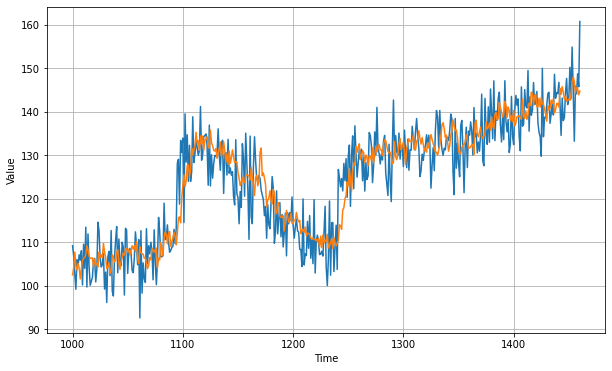

In [26]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7102

## 케라스 튜너로 하이퍼파라미터 튜닝하기
적절한 하이퍼파라미터를 랜덤값으로 돌아가면서 찾아내라

In [25]:
%pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 172.1/172.1 kB 10.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


units = Dense 뉴런의 범위를 지정   
momentum = 값들 중에 랜덤으로 지정

In [26]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=30, step=2), 
        activation='relu', input_shape=[window_size]))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    sgd = tf.keras.optimizers.SGD(
        learning_rate=1e-6,
        momentum=hp.Choice('momentum', values=[.9, .7, .5, .3]))
    model.compile(loss="mse", optimizer=sgd)
    return model

위에서 만들어준 모델을 랜덤하게 실행시켜줄 메서드 필요 ▼ RandomSearch
RandomSearch(모델 함수명,
             objective는 손실값이 줄어드는 것을 확인하고 싶으니까 'loss', 최대 150번까지 시도 해라,
             executions_per_trial = 모델 훈련과 평가 횟수 지정, 'my_dir'에 'hello'라는 이름으로 결과 저장)

In [27]:
from keras_tuner.tuners import RandomSearch

In [28]:
tuner = RandomSearch(build_model,
                     objective='loss', max_trials=150, 
                     executions_per_trial=3, directory='my_dir', 
                     project_name='hello', overwrite=True)

실제 실행 ▼

In [29]:
tuner.search(dataset, epochs=100, verbose=0)

Traceback (most recent call last):
  File "C:\Users\Playdata\AppData\Roaming\Python\Python39\site-packages\keras_tuner\engine\base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Playdata\AppData\Roaming\Python\Python39\site-packages\keras_tuner\engine\base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Playdata\AppData\Roaming\Python\Python39\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Playdata\AppData\Roaming\Python\Python39\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\Playdata\AppData\Roaming\Python\Python39\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwa

Traceback (most recent call last):
  File "C:\Users\Playdata\AppData\Roaming\Python\Python39\site-packages\keras_tuner\engine\base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Playdata\AppData\Roaming\Python\Python39\site-packages\keras_tuner\engine\base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Playdata\AppData\Roaming\Python\Python39\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Playdata\AppData\Roaming\Python\Python39\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\Playdata\AppData\Roaming\Python\Python39\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwa

INFO:tensorflow:Oracle triggered exit


In [30]:
tuner.results_summary()

Results summary
Results in my_dir\hello
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 031 summary
Hyperparameters:
units: 30
momentum: 0.9
Score: 32.87590789794922

Trial 025 summary
Hyperparameters:
units: 22
momentum: 0.9
Score: 33.639549255371094

Trial 024 summary
Hyperparameters:
units: 26
momentum: 0.9
Score: 33.737972259521484

Trial 022 summary
Hyperparameters:
units: 28
momentum: 0.9
Score: 33.98737335205078

Trial 000 summary
Hyperparameters:
units: 14
momentum: 0.9
Score: 34.24246597290039

Trial 041 summary
Hyperparameters:
units: 20
momentum: 0.9
Score: 34.74824905395508

Trial 017 summary
Hyperparameters:
units: 18
momentum: 0.9
Score: 34.890279134114586

Trial 012 summary
Hyperparameters:
units: 24
momentum: 0.9
Score: 34.91199493408203

Trial 008 summary
Hyperparameters:
units: 16
momentum: 0.9
Score: 35.31044006347656

Trial 034 summary
Hyperparameters:
units: 28
momentum: 0.5
Score: 35.327457427978516


In [34]:
best_models = tuner.get_best_models(num_models=4)

In [35]:
model = best_models[0]

forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 18ms/step


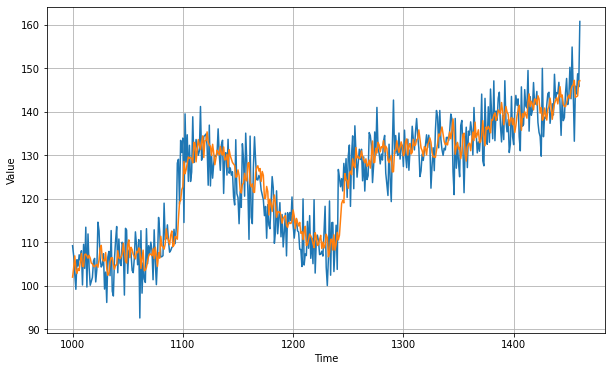

In [36]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6166816